In [1]:
# REFERENCE
# https://stellargraph.readthedocs.io/en/stable/demos/node-classification/rgcn-node-classification.html

# Import Libraries

In [2]:
from rdflib.extras.external_graph_libs import *
from rdflib import Graph, URIRef, Literal

import networkx as nx
from networkx.classes.function import info

import stellargraph as sg
from stellargraph.mapper import RelationalFullBatchNodeGenerator
from stellargraph.layer import RGCN

import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model

import sklearn
from sklearn import model_selection, preprocessing
from collections import Counter
from stellargraph import datasets
from IPython.display import display, HTML
import matplotlib.pyplot as plt
%matplotlib inline

# R-GCN Entity Classification Experiment Replication 

The paper performed entity classification experimentations on the AIFB, MUTAG, BGS and AM datasets and were run on CPU nodes with 64GB of memory.

We will replicate the AIFB experiment locally with the StellarGraph Machine Learning Library's implementation of R-GCN, and perform experiments on other datasets, namely:
1. Cora
2. Citeseer

# AIFB Experiment Replication

In the paper, R-GCN achieved average accuracy of 95.83 for AIFB dataset.

In [3]:
# 1.Loading Data
dataset = datasets.AIFB()
display(HTML(dataset.description))
G, affiliation = dataset.load()

In [4]:
# 2.Input Preparation
train_targets, test_targets = model_selection.train_test_split(
    affiliation, train_size=0.8, test_size=0.2
)

In [5]:
generator = RelationalFullBatchNodeGenerator(G, sparse=True)
train_gen = generator.flow(train_targets.index, targets=train_targets)
test_gen = generator.flow(test_targets.index, targets=test_targets)

In [6]:
# 3.RGCN model creation and training
rgcn = RGCN(
    layer_sizes=[16, 16],
    activations=["relu", "relu"],
    generator=generator,
    bias=True,
    num_bases=0,
    dropout=0.5,
)

In [7]:
x_in, x_out = rgcn.in_out_tensors()
predictions = Dense(train_targets.shape[-1], activation="softmax")(x_out)
model = Model(inputs=x_in, outputs=predictions)
model.compile(
    loss="categorical_crossentropy",
    optimizer=keras.optimizers.Adam(0.01),
    metrics=["acc"],
)

In [8]:
history = model.fit(train_gen, validation_data=test_gen, epochs=50)

Epoch 1/50
1/1 [==============================] - 24s 24s/step - loss: 1.6090 - acc: 0.3239 - val_loss: 1.5732 - val_acc: 0.6111
Epoch 2/50
1/1 [==============================] - 18s 18s/step - loss: 1.5475 - acc: 0.6831 - val_loss: 1.5264 - val_acc: 0.6944
Epoch 3/50
1/1 [==============================] - 18s 18s/step - loss: 1.4927 - acc: 0.6831 - val_loss: 1.4656 - val_acc: 0.6944
Epoch 4/50
1/1 [==============================] - 18s 18s/step - loss: 1.4156 - acc: 0.8028 - val_loss: 1.3978 - val_acc: 0.6944
Epoch 5/50
1/1 [==============================] - 18s 18s/step - loss: 1.3260 - acc: 0.7676 - val_loss: 1.3248 - val_acc: 0.6944
Epoch 6/50
1/1 [==============================] - 17s 17s/step - loss: 1.2067 - acc: 0.8380 - val_loss: 1.2484 - val_acc: 0.6944
Epoch 7/50
1/1 [==============================] - 16s 16s/step - loss: 1.2003 - acc: 0.7887 - val_loss: 1.1725 - val_acc: 0.6944
Epoch 8/50
1/1 [==============================] - 16s 16s/step - loss: 1.0690 - acc: 0.8169 - val

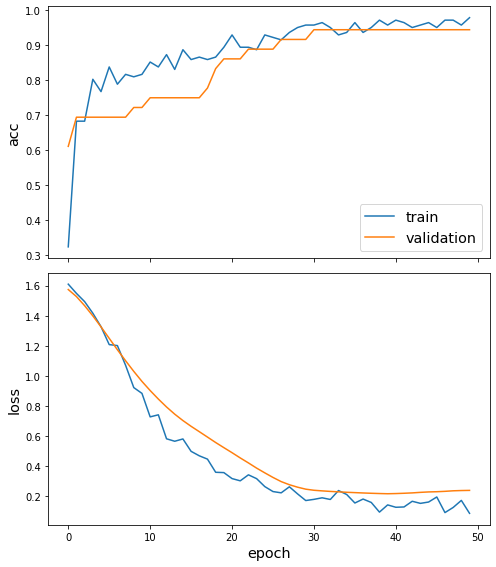

In [9]:
sg.utils.plot_history(history)

In [10]:
test_metrics = model.evaluate(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

1/1 [==============================] - 3s 3s/step - loss: 0.2366 - acc: 0.9444

Test Set Metrics:
	loss: 0.2366
	acc: 0.9444


# Cora Dataset

In [11]:
dataset = datasets.Cora()
display(HTML(dataset.description))
G, node_subjects = dataset.load()

In [12]:
node_subjects.value_counts().to_frame()

,subject
Neural_Networks,818
Probabilistic_Methods,426
Genetic_Algorithms,418
Theory,351
Case_Based,298
Reinforcement_Learning,217
Rule_Learning,180


In [13]:
train_subjects, test_subjects = model_selection.train_test_split(
    node_subjects, train_size=0.8, test_size=0.2, stratify=node_subjects
)

In [14]:
target_encoding = preprocessing.LabelBinarizer()

train_targets = target_encoding.fit_transform(train_subjects)
test_targets = target_encoding.transform(test_subjects)

In [15]:
generator = RelationalFullBatchNodeGenerator(G, sparse=True)
train_gen = generator.flow(train_subjects.index, targets=train_targets)
test_gen = generator.flow(test_subjects.index, targets=test_targets)

In [60]:
rgcn = RGCN(
    layer_sizes=[16, 16],
    activations=["relu", "relu"],
    generator=generator,
    bias=True,
    num_bases=0,
    dropout=0.5,
)

In [61]:
x_in, x_out = rgcn.in_out_tensors()
predictions = Dense(train_targets.shape[-1], activation="softmax")(x_out)
model = Model(inputs=x_in, outputs=predictions)
model.compile(
    loss="categorical_crossentropy",
    optimizer=keras.optimizers.Adam(0.01),
    metrics=["acc"],
)

In [62]:
history = model.fit(train_gen, validation_data=test_gen, epochs=50)

Epoch 1/50
1/1 [==============================] - 1s 1s/step - loss: 1.8423 - acc: 0.1789 - val_loss: 1.7092 - val_acc: 0.2891
Epoch 2/50
1/1 [==============================] - 0s 169ms/step - loss: 1.6897 - acc: 0.3104 - val_loss: 1.5887 - val_acc: 0.3578
Epoch 3/50
1/1 [==============================] - 0s 140ms/step - loss: 1.5941 - acc: 0.3442 - val_loss: 1.4484 - val_acc: 0.4100
Epoch 4/50
1/1 [==============================] - 0s 137ms/step - loss: 1.4496 - acc: 0.3981 - val_loss: 1.3516 - val_acc: 0.4763
Epoch 5/50
1/1 [==============================] - 0s 152ms/step - loss: 1.3837 - acc: 0.4437 - val_loss: 1.2501 - val_acc: 0.6043
Epoch 6/50
1/1 [==============================] - 0s 131ms/step - loss: 1.2730 - acc: 0.5130 - val_loss: 1.1234 - val_acc: 0.7322
Epoch 7/50
1/1 [==============================] - 0s 138ms/step - loss: 1.1367 - acc: 0.6102 - val_loss: 1.0109 - val_acc: 0.7654
Epoch 8/50
1/1 [==============================] - 0s 133ms/step - loss: 1.0289 - acc: 0.6665 

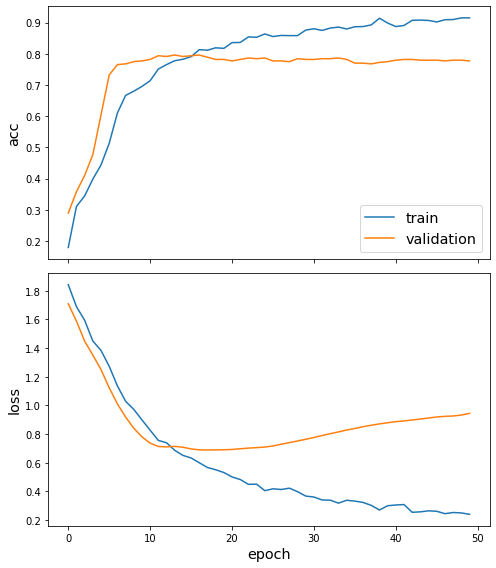

In [63]:
sg.utils.plot_history(history)

In [64]:
test_metrics = model.evaluate(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

1/1 [==============================] - 0s 65ms/step - loss: 0.9448 - acc: 0.7773

Test Set Metrics:
	loss: 0.9448
	acc: 0.7773


# Citeseer Dataset

In [65]:
dataset = datasets.CiteSeer()
display(HTML(dataset.description))
G, subjects = dataset.load(largest_connected_component_only=True)

In [66]:
train_subjects, test_subjects = model_selection.train_test_split(
    subjects, train_size=0.8, test_size=0.2, stratify=subjects
)

In [67]:
target_encoding = preprocessing.LabelBinarizer()

train_targets = target_encoding.fit_transform(train_subjects)
test_targets = target_encoding.transform(test_subjects)

In [68]:
generator = RelationalFullBatchNodeGenerator(G, sparse=True)

train_gen = generator.flow(train_subjects.index, targets=train_targets)
test_gen = generator.flow(test_subjects.index, targets=test_targets)

In [69]:
rgcn = RGCN(
    layer_sizes=[16, 16],
    activations=["relu", "relu"],
    generator=generator,
    bias=True,
    num_bases=0,
    dropout=0.5,
)

In [70]:
x_in, x_out = rgcn.in_out_tensors()
predictions = Dense(train_targets.shape[-1], activation="softmax")(x_out)
model = Model(inputs=x_in, outputs=predictions)
model.compile(
    loss="categorical_crossentropy",
    optimizer=keras.optimizers.Adam(0.01),
    metrics=["acc"],
)

In [71]:
history = model.fit(train_gen, validation_data=test_gen, epochs=50)

Epoch 1/50
1/1 [==============================] - 1s 875ms/step - loss: 1.7836 - acc: 0.2103 - val_loss: 1.5978 - val_acc: 0.3839
Epoch 2/50
1/1 [==============================] - 0s 137ms/step - loss: 1.5880 - acc: 0.3744 - val_loss: 1.4038 - val_acc: 0.4929
Epoch 3/50
1/1 [==============================] - 0s 140ms/step - loss: 1.4289 - acc: 0.4461 - val_loss: 1.2415 - val_acc: 0.5664
Epoch 4/50
1/1 [==============================] - 0s 138ms/step - loss: 1.2791 - acc: 0.5308 - val_loss: 1.1210 - val_acc: 0.6280
Epoch 5/50
1/1 [==============================] - 0s 139ms/step - loss: 1.1402 - acc: 0.5960 - val_loss: 1.0256 - val_acc: 0.6801
Epoch 6/50
1/1 [==============================] - 0s 131ms/step - loss: 1.0359 - acc: 0.6540 - val_loss: 0.9508 - val_acc: 0.7180
Epoch 7/50
1/1 [==============================] - 0s 135ms/step - loss: 0.9255 - acc: 0.6973 - val_loss: 0.9003 - val_acc: 0.7441
Epoch 8/50
1/1 [==============================] - 0s 138ms/step - loss: 0.8818 - acc: 0.69

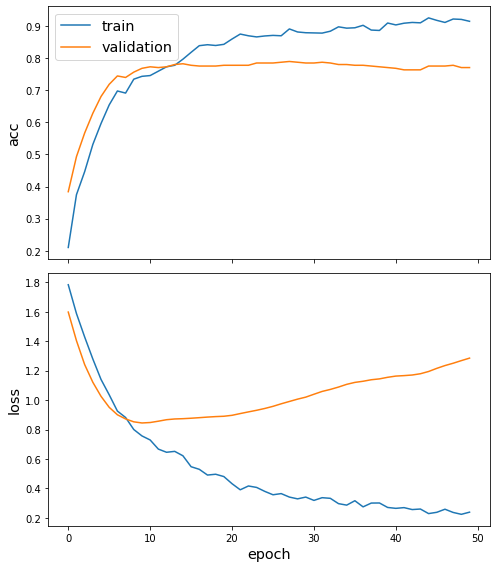

In [72]:
sg.utils.plot_history(history)

In [73]:
test_metrics = model.evaluate(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

1/1 [==============================] - 0s 53ms/step - loss: 1.2851 - acc: 0.7701

Test Set Metrics:
	loss: 1.2851
	acc: 0.7701
